In [2]:
import cartopy.crs as ccrs
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KernelDensity

In [3]:
real = pd.read_pickle('../data_cabspotting/cabspotting_cut.pkl')
fake = pd.read_pickle('../machine_learning/generated/citybased_rnn_2/GRU-32_TD-Dense-3_cabspotting_64_100_adam_mae_default_cut.pkl')

In [3]:
# Load the OSMNX graphs
streets_small = ox.load_graphml('san_francisco_streets_all.graphml', folder='../osmnx_data')

In [ ]:
streets = ox.load_graphml('cabspotting_streets_all.graphml', folder='../osmnx_data')

## Simple overview (small map)

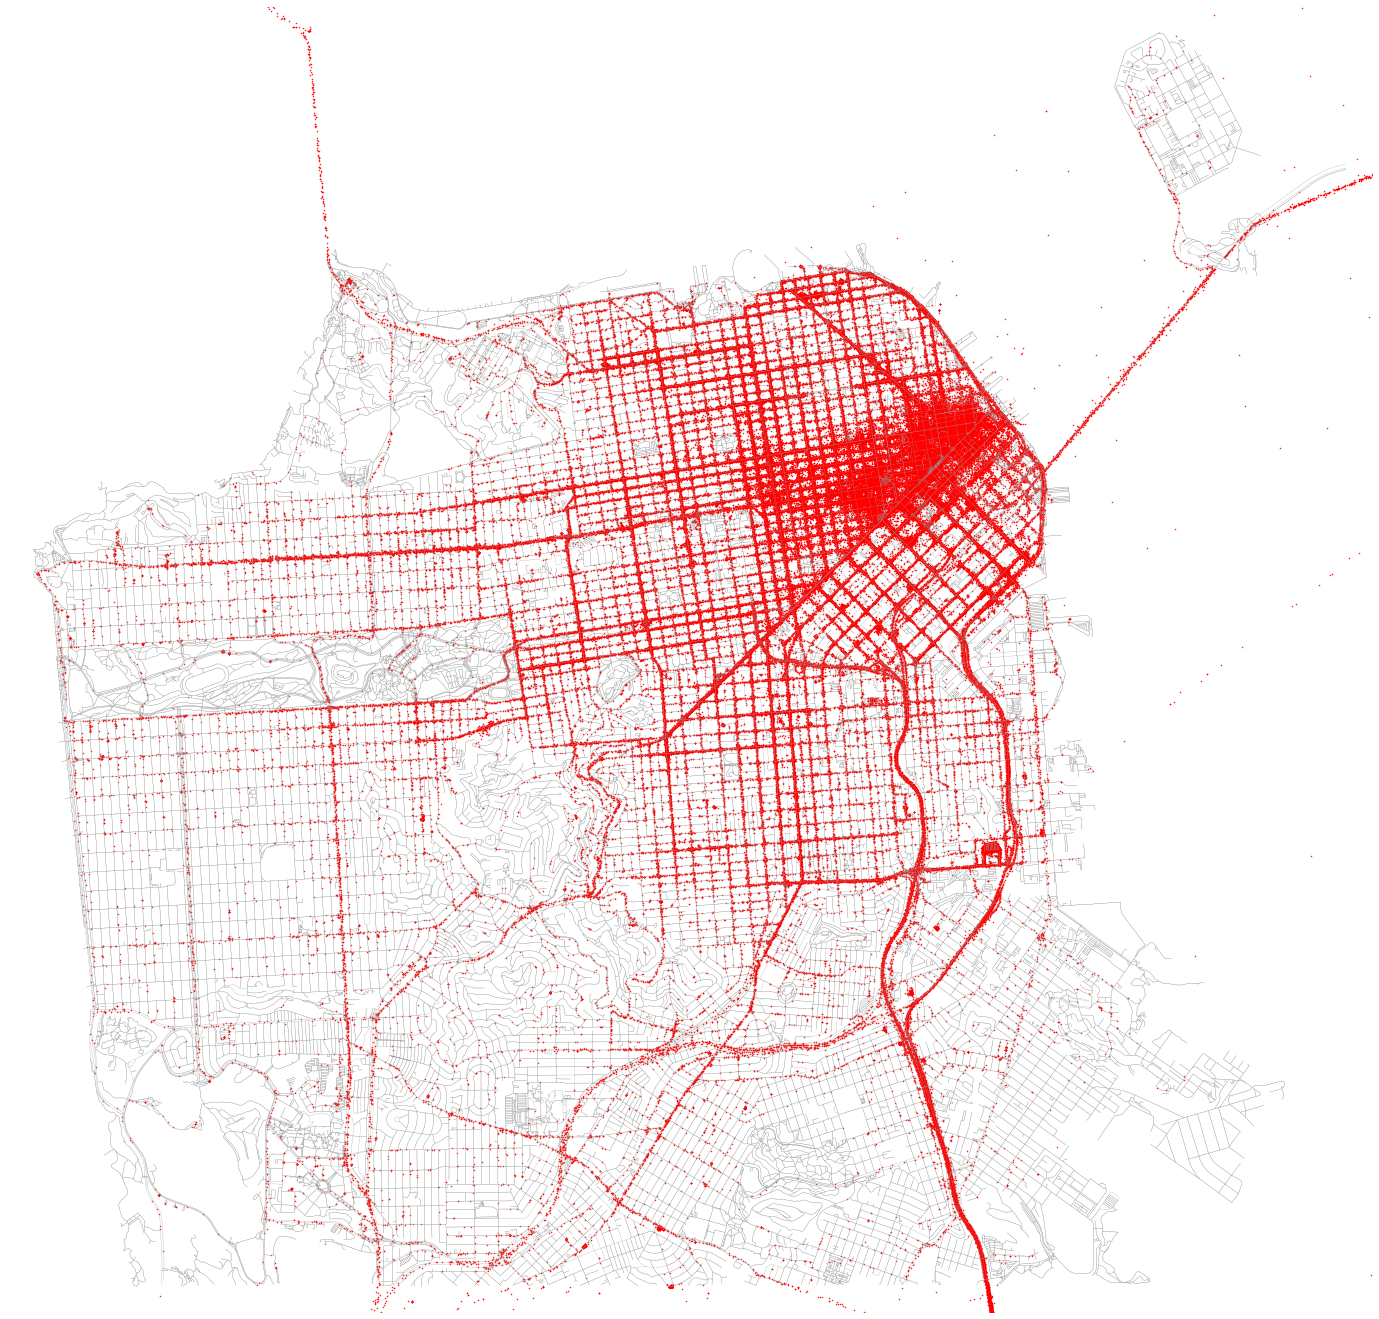

In [5]:
fig, ax = ox.plot_graph(streets_small, fig_height=24, node_size=0, edge_linewidth=0.25, show=False, close=False)
ax.scatter(real['longitude'], real['latitude'], c='#ff0000', s=0.25, alpha=1.0)

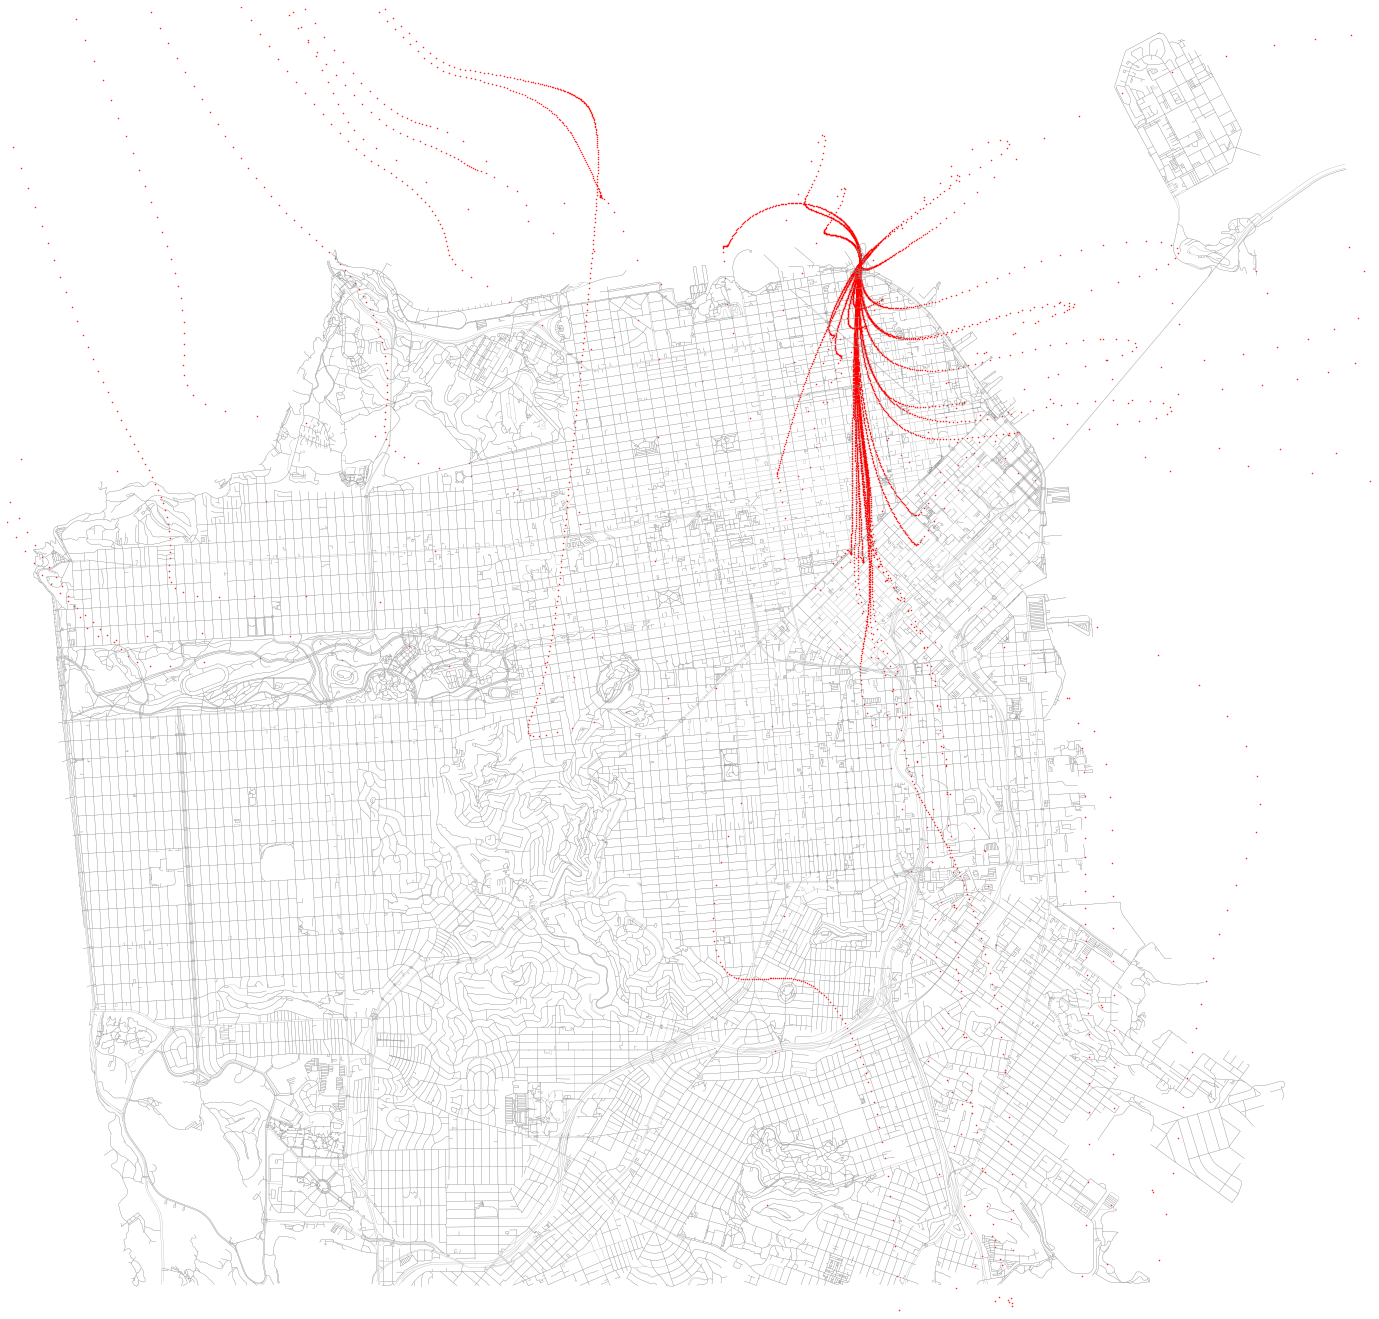

In [6]:
fig, ax = ox.plot_graph(streets_small, fig_height=24, node_size=0, edge_linewidth=0.25, show=False, close=False)
ax.scatter(fake['longitude'], fake['latitude'], c='#ff0000', s=0.25, alpha=1.0)

## Simple overview (large map)

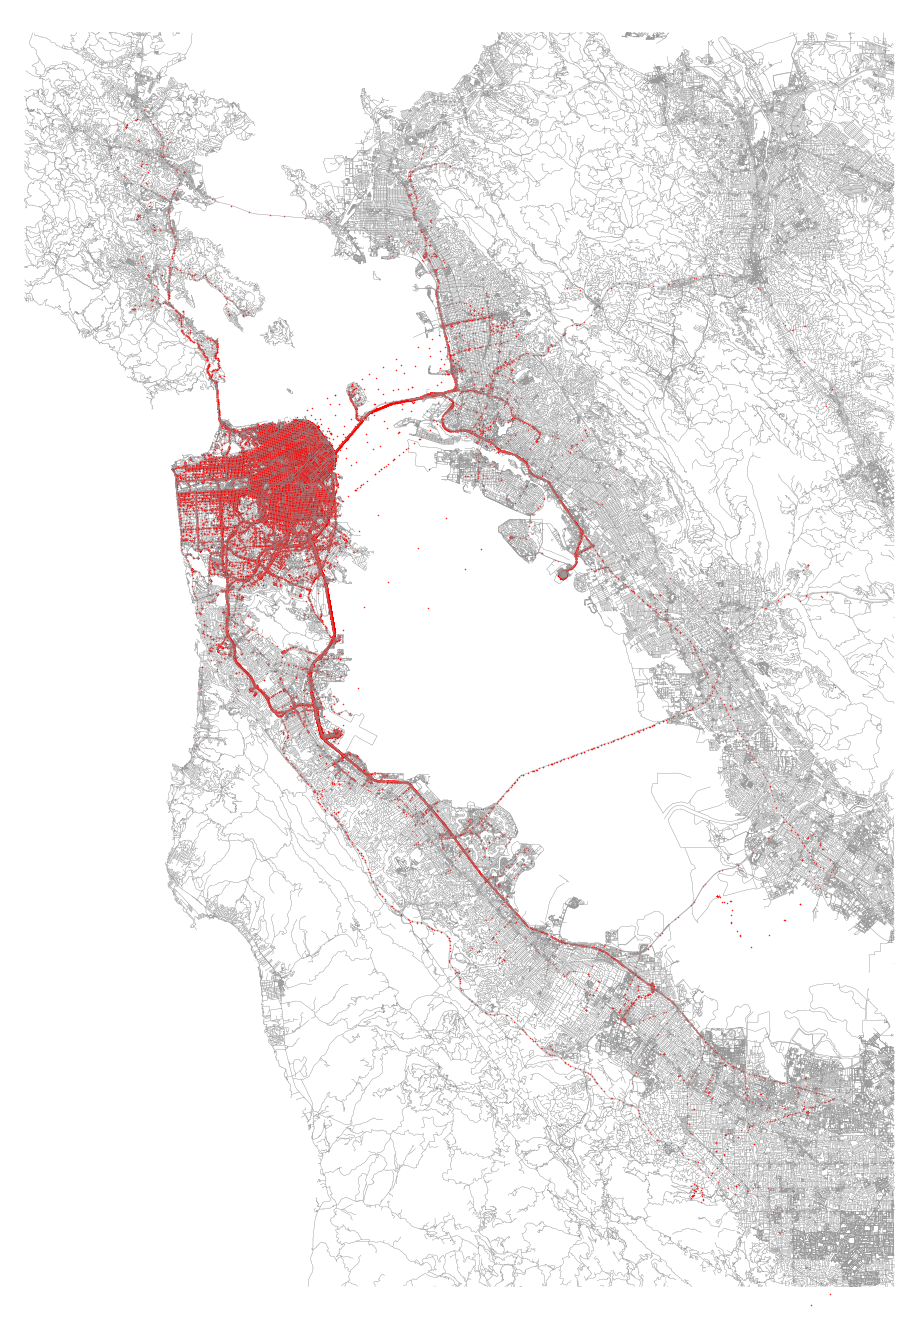

In [19]:
fig, ax = ox.plot_graph(streets, fig_height=24, node_size=0, edge_linewidth=0.25, show=False, close=False)
ax.scatter(real['longitude'], real['latitude'], c='#ff0000', s=0.25, alpha=1.0)

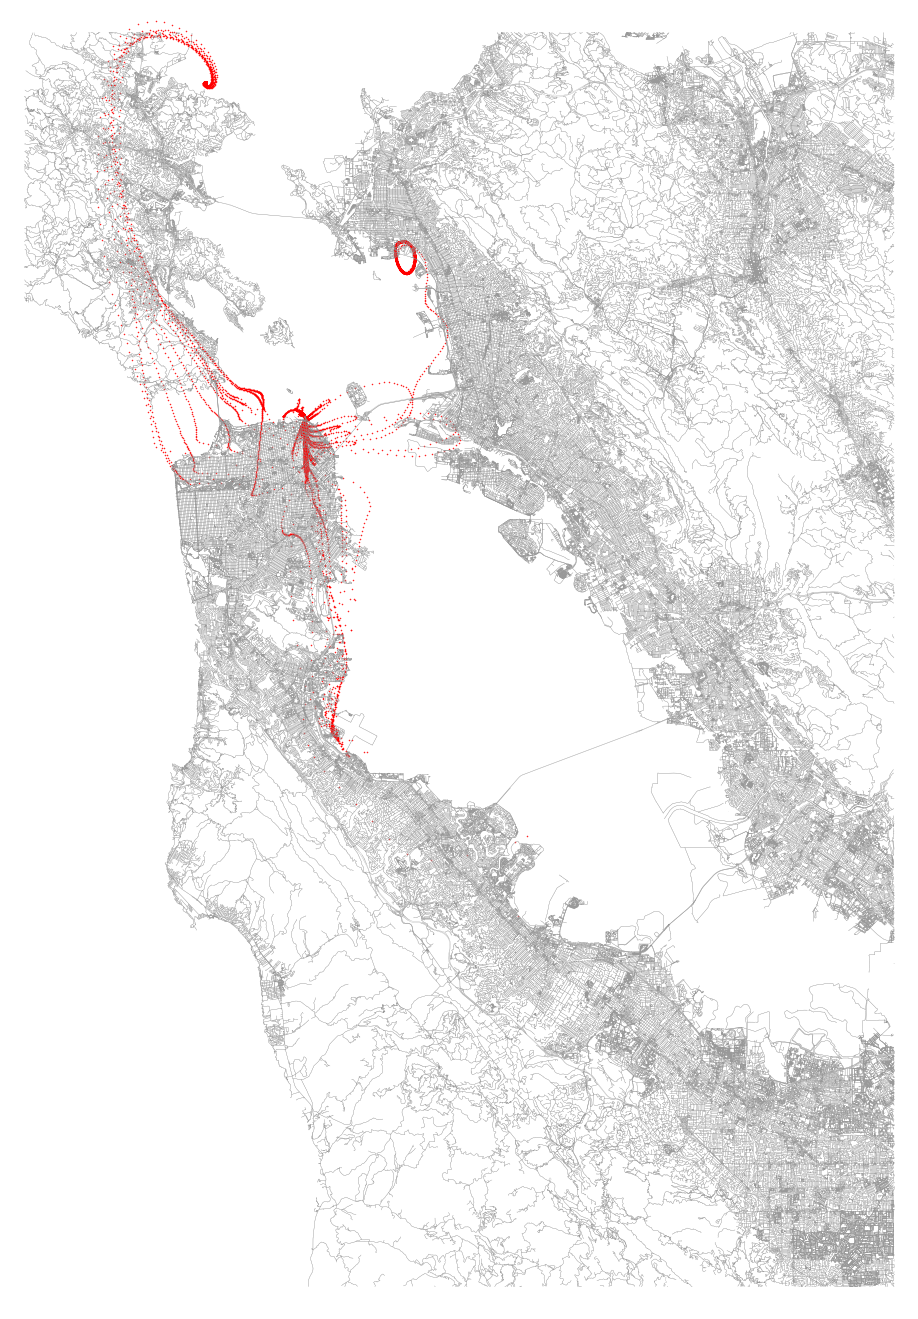

In [20]:
fig, ax = ox.plot_graph(streets, fig_height=24, node_size=0, edge_linewidth=0.25, show=False, close=False)
ax.scatter(fake['longitude'], fake['latitude'], c='#ff0000', s=0.25, alpha=1.0)

## Histogram of # records in every hour

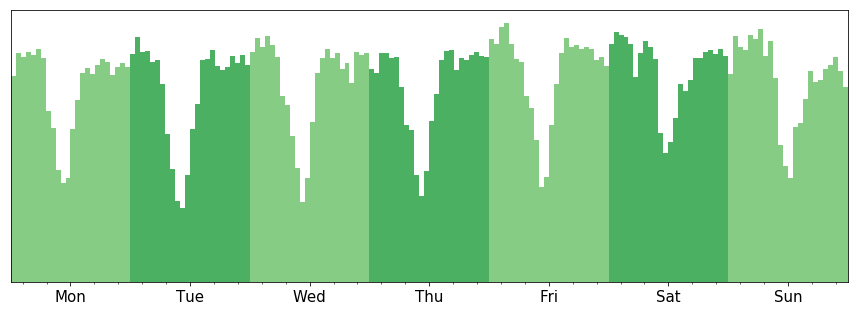

In [50]:
plt.figure(figsize=(15, 5))
_, _, patches = plt.hist(real.index.levels[1], bins=168,
                         range=(pd.Timestamp('2008-06-02 00:00:00'), pd.Timestamp('2008-06-08 23:59:59')))
cm = plt.cm.Greens
colours = ([0.45]*24 + [0.6]*24)*7
for c, p in zip(colours, patches):
    plt.setp(p, 'facecolor', cm(c))
plt.xlim(pd.Timestamp('2008-06-02 00:00:00'), pd.Timestamp('2008-06-08 23:59:59'))
plt.xticks([pd.Timestamp('2008-06-02 12:00:00'), pd.Timestamp('2008-06-03 12:00:00'),
           pd.Timestamp('2008-06-04 12:00:00'), pd.Timestamp('2008-06-05 12:00:00'),
           pd.Timestamp('2008-06-06 12:00:00'), pd.Timestamp('2008-06-07 12:00:00'),
           pd.Timestamp('2008-06-08 12:00:00')], 
           ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.yticks([])
plt.minorticks_on()
plt.tick_params(labelsize=15.0)
plt.show()

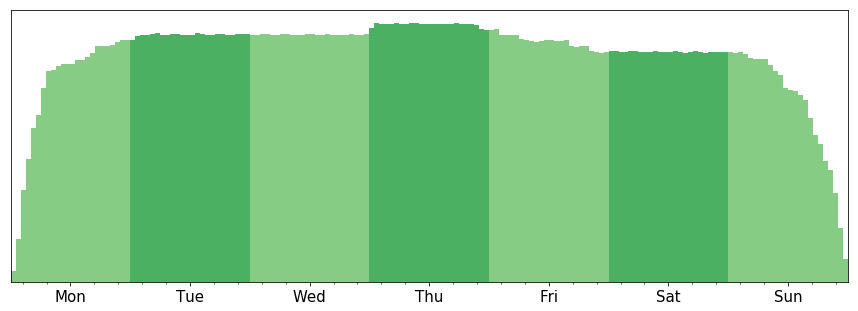

In [49]:
plt.figure(figsize=(15, 5))
_, _, patches = plt.hist(fake.index.levels[1], bins=168,
                         range=(pd.Timestamp('2008-06-02 00:00:00'), pd.Timestamp('2008-06-08 23:59:59')))
cm = plt.cm.Greens
colours = ([0.45]*24 + [0.6]*24)*7
for c, p in zip(colours, patches):
    plt.setp(p, 'facecolor', cm(c))
plt.xlim(pd.Timestamp('2008-06-02 00:00:00'), pd.Timestamp('2008-06-08 23:59:59'))
plt.xticks([pd.Timestamp('2008-06-02 12:00:00'), pd.Timestamp('2008-06-03 12:00:00'),
           pd.Timestamp('2008-06-04 12:00:00'), pd.Timestamp('2008-06-05 12:00:00'),
           pd.Timestamp('2008-06-06 12:00:00'), pd.Timestamp('2008-06-07 12:00:00'),
           pd.Timestamp('2008-06-08 12:00:00')], 
           ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.yticks([])
plt.minorticks_on()
plt.tick_params(labelsize=15.0)
plt.show()

## Distribution of speeds

In [4]:
def haversine(lat1, lon1, lat2, lon2):
    MILES = 3959
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    total_miles = MILES * c
    return total_miles * 1.6

def speed_distribution(ds):
    tmp = ds.reset_index()
    delta_t = tmp.groupby('user')['time'].diff().dt.total_seconds()
    delta_t = delta_t / 3600.0
    prvs_poss = tmp.groupby('user')[['latitude', 'longitude']].shift(1)
    delta_w = haversine(prvs_poss['latitude'], prvs_poss['longitude'], tmp['latitude'], tmp['longitude'])
    speeds = delta_w / delta_t
    
    print(speeds.describe())
    
    plt.figure(figsize=(15, 5))
    plt.hist(speeds, bins=range(0, 150))
    plt.xlim(0, 150)
    plt.yticks([])
    plt.minorticks_on()
    plt.tick_params(labelsize=15.0)
    plt.show()

/Users/jankaiser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in arcsin
  import sys


count    348465.000000
mean         30.417233
std        1163.740611
min           0.000000
25%           3.310669
50%          14.725242
75%          27.342158
max      614887.760159
dtype: float64


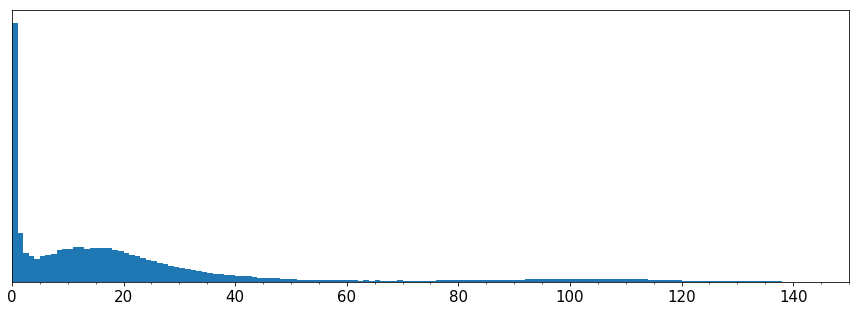

In [5]:
speed_distribution(real)

/Users/jankaiser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in arcsin
  import sys


count    404007.000000
mean          0.346336
std           3.036906
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         209.411085
dtype: float64


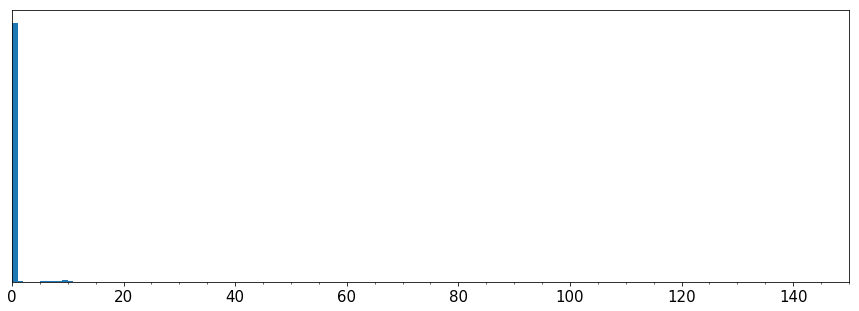

In [6]:
speed_distribution(fake)

## One user's data

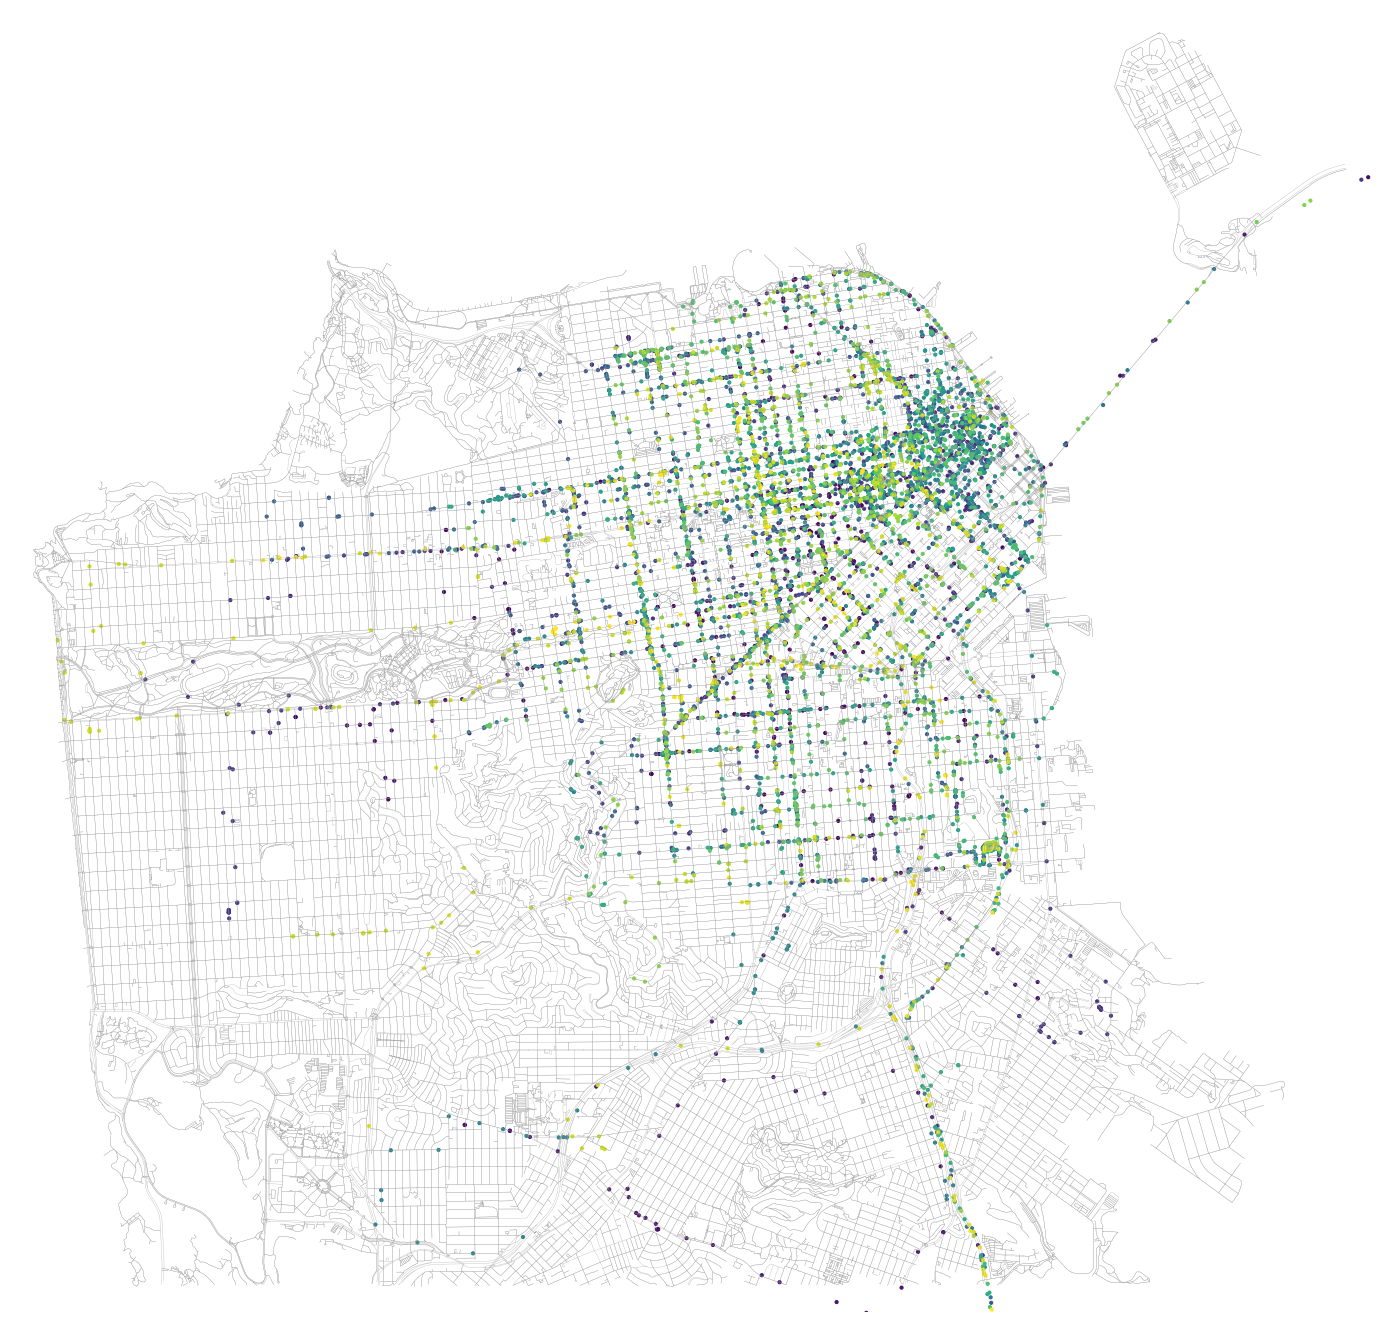

In [25]:
user = 'ektamy'
fig, ax = ox.plot_graph(streets_small, fig_height=24, node_size=0, edge_linewidth=0.25, show=False, close=False)
ax.scatter(real.loc[user]['longitude'], real.loc[user]['latitude'], c=real.loc[user].index, s=10.0, alpha=1.0)

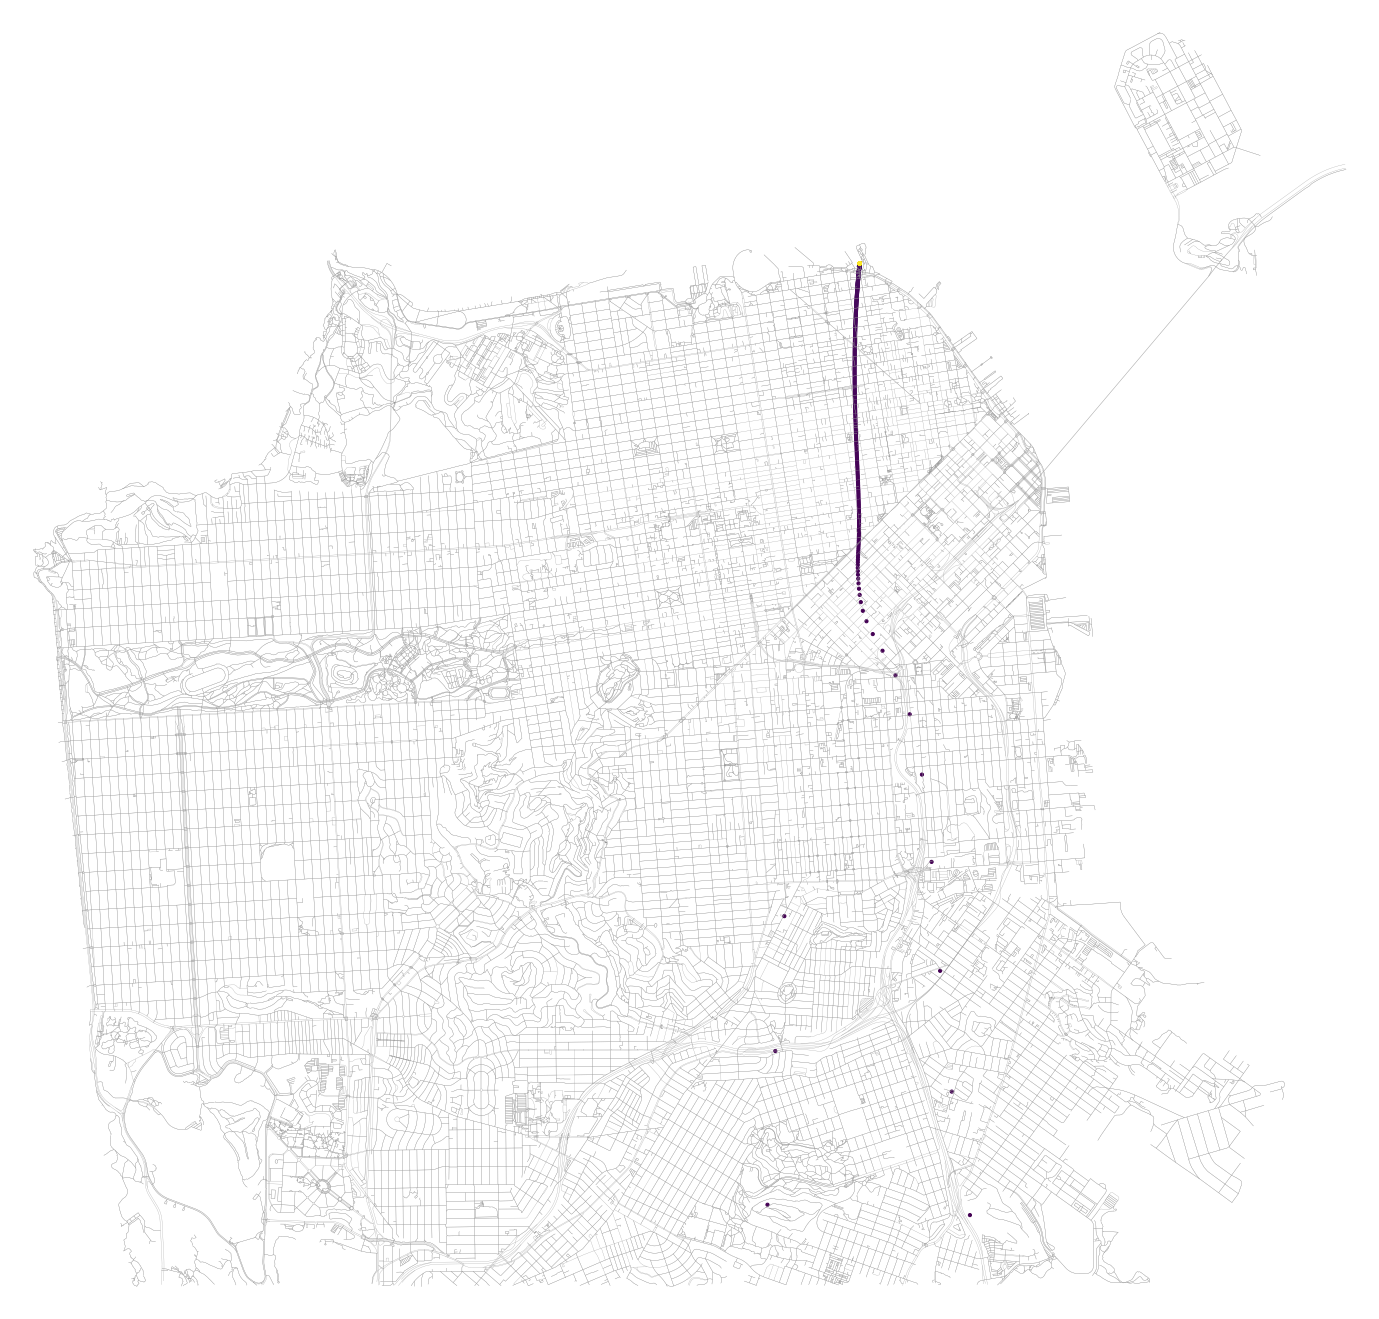

In [26]:
user = 4
fig, ax = ox.plot_graph(streets_small, fig_height=24, node_size=0, edge_linewidth=0.25, show=False, close=False)
ax.scatter(fake.loc[user]['longitude'], fake.loc[user]['latitude'], c=fake.loc[user].index, s=10.0, alpha=1.0)